In [1]:
# Importing

import numpy as np
import torch
from transformers import logging
from transformers import AutoModelForMaskedLM, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [2]:
# Loading transformer

from transformers import T5Tokenizer, MT5ForConditionalGeneration
# model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small").to("cuda:0")
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small").to("cpu")
tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
# Defining function for scoring words in a sentence

def score_words(sentence):
  words = sentence.split()
  scores = []
  for i in range(len(words)):
    intext = ' '.join(words[:i] + ['<extra_id_0>'] + words[i+1:])
    outtext = '<extra_id_0> ' + words[i] + ' <extra_id_1>'
    # toks = tokenizer(intext, text_target=outtext, return_tensors="pt").to("cuda:0")
    toks = tokenizer(intext, text_target=outtext, return_tensors="pt").to("cpu")
    out = model(**toks)
    scores.append(out.loss.item() * toks.labels.shape[1])
    #print(toks.labels)
  return scores

In [4]:
# Loading the database with examples

df = pd.read_csv('czech_examples_database.csv')

In [5]:
# Sampling few sentences from the database

df1 = df[:5]

In [6]:
# Defining function for creating heatmap plot for words' scores

def create_grid_heatmap(sentence):
    words = sentence.split()
    scores = score_words(sentence)

    # Normalize scores for color mapping
    norm = Normalize(vmin=min(scores), vmax=max(scores))
    cmap = plt.cm.viridis  # Choose a colormap

    # Create a grid layout
    num_words = len(words)
    fig, ax = plt.subplots(figsize=(num_words, 2))
    ax.set_xticks(np.arange(num_words))
    ax.set_yticks([0])  # Only one row for a single sentence
    ax.set_xticklabels(words, fontsize=10)
    ax.set_yticklabels([''])  # Empty label for y-axis
    ax.tick_params(axis="x", bottom=False, top=False)
    ax.tick_params(axis="y", left=False, right=False)

    # Plot the grid heatmap
    for i, (word, score) in enumerate(zip(words, scores)):
        # Draw background color
        rect = plt.Rectangle((i - 0.5, -0.5), 1, 1, color=cmap(norm(score)))
        ax.add_patch(rect)
        # Add word text
        ax.text(i, 0.2, word, ha='center', va='center', fontsize=12, 
                color='white' if norm(score) > 0.5 else 'black')
        # Add score value
        ax.text(i, -0.3, f'{score:.1f}', ha='center', va='center', fontsize=10,
                color='white' if norm(score) > 0.5 else 'black')

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for the colorbar
    fig.colorbar(sm, orientation='horizontal', ax=ax, pad=0.2, label='Word Score')

    # Remove gridlines and extra axes
    ax.set_xlim(-0.5, num_words - 0.5)
    ax.set_ylim(-0.6, 0.6)
    ax.axis('off')

    # Show the heatmap
    plt.show()

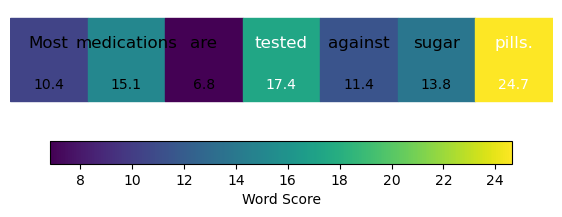

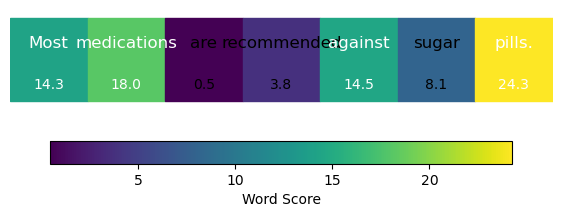

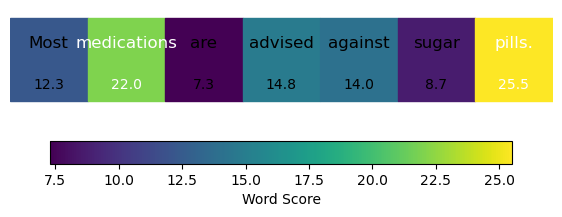

In [7]:
# Example sentences in English

sentence = "Most medications are tested against sugar pills."
create_grid_heatmap(sentence)
sentence2 = "Most medications are recommended against sugar pills."
create_grid_heatmap(sentence2)
sentence3 = "Most medications are advised against sugar pills."
create_grid_heatmap(sentence3)

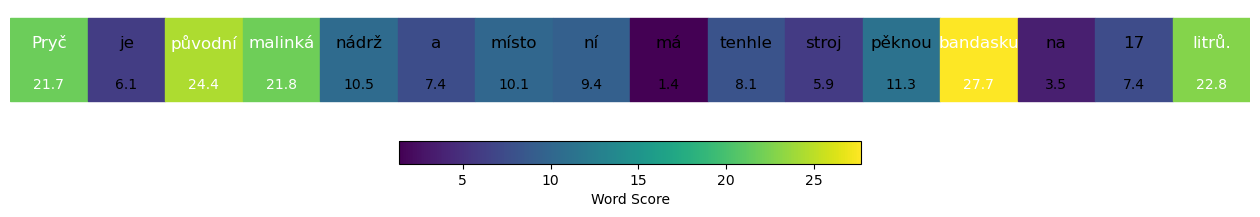

In [8]:
# Example sentence in Czech

sentence = "Pryč je původní malinká nádrž a místo ní má tenhle stroj pěknou bandasku na 17 litrů."
create_grid_heatmap(sentence)

In [9]:
# Removing the brackets around the keywords from the sampled dataframe

df1['example'] = df1['example'].str.replace(r'[<>]', '', regex=True)

C:\Users\user\AppData\Local\Temp\ipykernel_12340\1565385440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['example'] = df1['example'].str.replace(r'[<>]', '', regex=True)


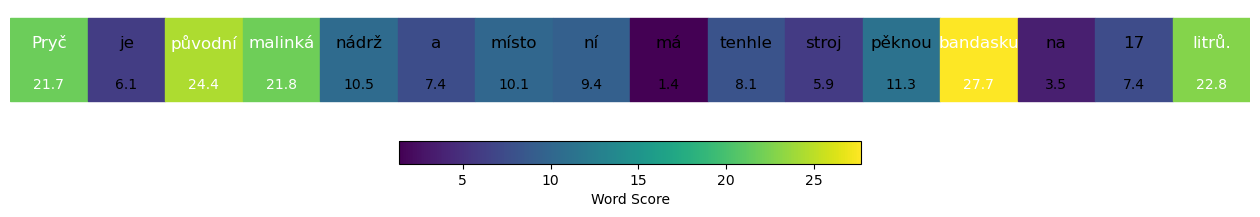

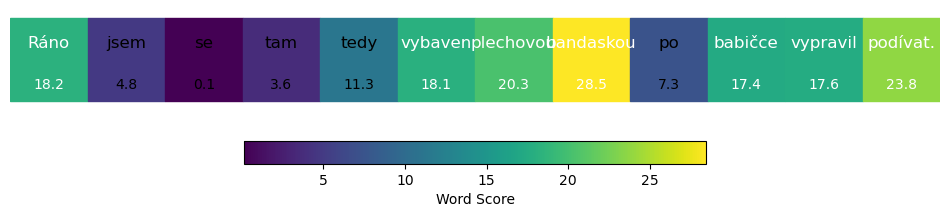

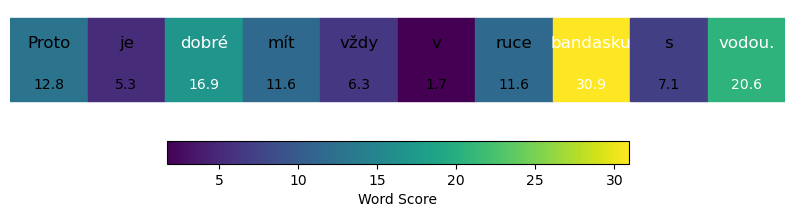

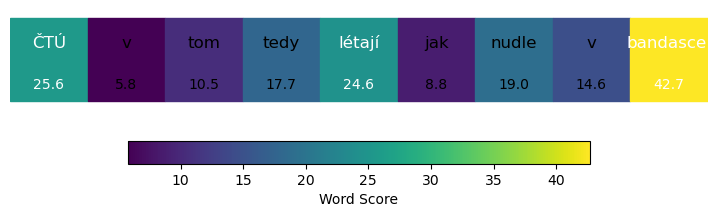

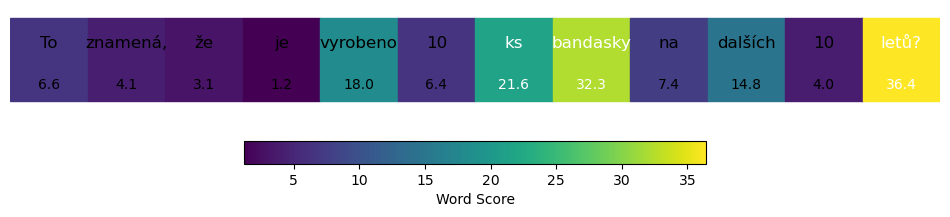

In [10]:
# Plotting graphs for the sentences in the sampled dataframe

for i, row in df1.iterrows():
    example = row['example']
    create_grid_heatmap(example)